In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
from scipy.interpolate import griddata

In [3]:
connectivity_min, connectivity_max = 0,15
delay_min, delay_max = 0,5
# random_input_span = (1.2,2.8)
random_input_span = (9.5,9.5)
total_time = 100
alpha = 20
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational','Non_repulsive_rotational']
neuron_model = current_models[2]

model_folder_name = neuron_model+'_ensembles'
version = '_v2.0'
# version = '_v1.0'
# version = '_cluster_computed'

# Capture related ensembles

In [4]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [5]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1]) + version
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [6]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}
field_max_intensity_mod_glossary_dict = {}

In [7]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    if g > connectivity_max or g < connectivity_min: continue #check if this connectivity is requested
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    field_max_intensity_mod_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        if delay > delay_max or delay < delay_min: continue #check if this connectivity is requested
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
            field_max_intensity_mod_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_properties.txt') ) as file:
                info_line = file.readline()
                field_period = float( info_line.split(',')[0] )
                max_intensity_mod = float( info_line.split(',')[1] )
                field_period_glossary_dict[g][delay].append( field_period )
                field_max_intensity_mod_glossary_dict[g][delay].append( max_intensity_mod )

            if neuron_model in ['Rotational','Non_repulsive_rotational']: #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(np.abs( field_period_glossary_dict[g][delay] ) )
        field_max_intensity_mod_glossary_dict[g][delay] = np.mean(field_max_intensity_mod_glossary_dict[g][delay])
        if neuron_model in ['Rotational','Non_repulsive_rotational']:amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


In [8]:
def dict_to_dataframe(input_dict):
    table = pd.DataFrame.from_dict(input_dict)
    table.index.name = 'delay'
    table.columns.name = 'connectivity'
    table = table.sort_index(axis=1)
    return table

def nested_dict_to_vectors(given_dict):
    coordinates = []
    for x in given_dict:
        for y in given_dict[x]:
            coordinates.append([x,y,given_dict[x][y]])
    return np.array(coordinates).T

def create_contour_phase_space(given_dict, title, plot_points = False):
    fig = plt.figure()
    ax = fig.add_subplot()
    
    grid_x, grid_y = np.mgrid[g_arr[0]:g_arr[-1]:500j, delay_arr[0]:delay_arr[-1]:500j]
    
    points = nested_dict_to_vectors(given_dict)[0:2].T
    values = nested_dict_to_vectors(given_dict)[2]
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

    extent = [min(g_arr),max(g_arr),min(delay_arr),max(delay_arr)]    
    
    filtered_grid = median_filter(grid_z.T, size = 20)
    
    ax.contourf(filtered_grid, extent = extent, cmap = 'inferno')
    C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)
    ax.clabel(C, inline=1, fontsize=10)
    
    if plot_points == True: ax.plot(points[:,0], points[:,1], 'w.', ms=1)
    
    ax.set_title('{} phase space'.format(title))
    ax.set_xlabel('Connectivity')
    ax.set_ylabel('Delay (s)')
    plt.close()
    return fig

In [9]:
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)

In [10]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
g_arr = np.sort( sigma_table.columns )
delay_arr = np.sort( sigma_table.index )

In [11]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

# Sigma dataframe

In [12]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
sigma_table.head()

connectivity,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5,15.0
delay,,,,,,,,,,,,,,,,,,,,,
0.10,0.027200,0.026809,0.026647,0.027066,0.027972,0.032851,0.036659,0.037389,0.030516,0.028550,...,0.361108,0.381131,0.395869,0.403856,0.410565,0.416701,0.420231,0.424755,0.426060,0.426923
0.25,0.027186,0.027290,0.027305,0.028033,0.029033,0.033659,0.033513,0.034172,0.031204,0.027918,...,0.583801,0.583186,0.582317,0.577693,0.580131,0.577079,0.575267,0.571934,0.571036,0.567392
0.50,0.027310,0.026418,0.026290,0.026715,0.028313,0.032845,0.037667,0.039019,0.036829,0.041273,...,0.656307,0.650375,0.650883,0.646644,0.642000,0.640753,0.637013,0.633840,0.625868,0.625830
0.75,0.027310,0.026494,0.024682,0.023427,0.024313,0.029998,0.036482,0.036594,0.032947,0.032409,...,0.678962,0.678025,0.673559,0.671796,0.667315,0.667501,0.660045,0.659881,0.649940,0.643294
1.00,0.027359,0.027031,0.027327,0.027333,0.028301,0.031953,0.031754,0.032472,0.024982,0.021614,...,0.690011,0.687101,0.681478,0.684588,0.678774,0.674335,0.668325,0.664830,0.664793,0.656054


C:\Users\mohsen\AppData\Local\Temp/ipykernel_5332/2442720307.py:7: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax_sigma.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))


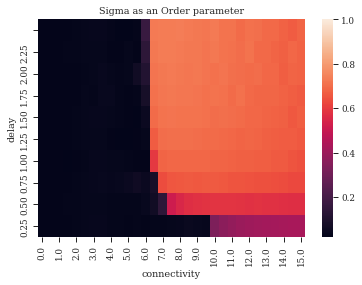

In [13]:
yticklabels = ['{:.2f}'.format(x) for x in sigma_table.index.to_list()]
ax_sigma = sns.heatmap(sigma_table, annot=False, vmax = 1)

ax_sigma.set_title('Sigma as an Order parameter')
ax_sigma.invert_yaxis()

ax_sigma.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))

In [14]:
fig = ax_sigma.get_figure()
fig.savefig(os.path.join(target_path, 'sigma_phase_space.png'), dpi = 1000)

C:\Users\mohsen\AppData\Local\Temp/ipykernel_5332/891229783.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


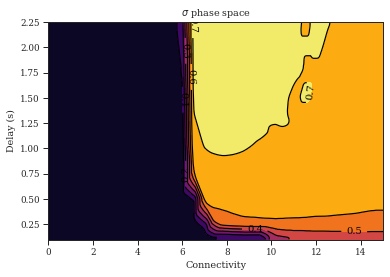

In [15]:
c_fig = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$')
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

C:\Users\mohsen\AppData\Local\Temp/ipykernel_5332/891229783.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


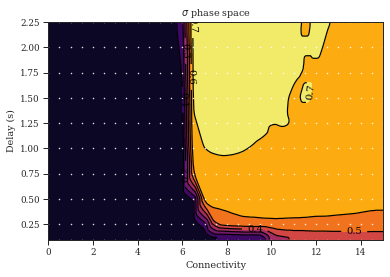

In [16]:
c_fig = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$', plot_points = True)
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_points_plotted_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

# Amin Saman Parameter

C:\Users\mohsen\AppData\Local\Temp/ipykernel_5332/891229783.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


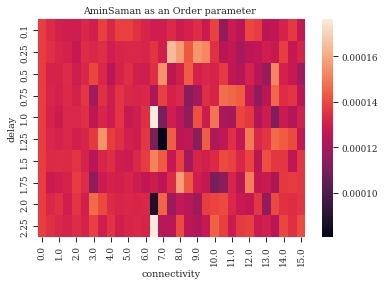

In [17]:
if neuron_model in ['Rotational','Non_repulsive_rotational']:
    amin_saman_param_table = dict_to_dataframe(amin_saman_param_glossary_dict)
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')
    fig = ax_field_period.get_figure()
    fig.savefig(os.path.join(target_path, 'amin_saman_phase_space.png'))
    
    create_contour_phase_space(amin_saman_param_glossary_dict, 'AminSaman').savefig(os.path.join(target_path, 'amin_saman_phase_space_contour.png'), dpi = 1000)

# Field period dataframe

In [18]:
field_period_table = dict_to_dataframe(field_period_glossary_dict)
field_period_table.head()

connectivity,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5,15.0
delay,,,,,,,,,,,,,,,,,,,,,
0.10,0.662252,0.714286,0.383142,0.819672,0.869565,0.141243,0.325733,0.515464,0.117096,0.378788,...,0.392157,0.404858,0.416667,0.427350,0.438596,0.450450,0.462963,0.473934,0.485437,0.497512
0.25,0.662252,0.714286,0.763359,0.819672,0.869565,0.141243,0.970874,0.258398,0.540541,0.568182,...,0.819672,0.847458,0.869565,0.884956,0.900901,0.925926,0.943396,0.970874,0.990099,1.010101
0.50,0.662252,0.714286,0.383142,0.819672,0.869565,0.141243,0.970874,1.030928,1.075269,1.136364,...,1.492537,1.538462,1.562500,1.612903,1.666667,1.694915,1.724138,1.754386,1.818182,1.851852
0.75,100.000000,100.000000,3.225806,2.325581,2.040816,0.141243,0.325733,0.515464,1.724138,0.568182,...,2.173913,2.222222,2.272727,2.325581,2.380952,2.439024,2.500000,2.564103,2.631579,2.702703
1.00,100.000000,100.000000,4.000000,2.941176,2.631579,2.500000,2.380952,2.325581,2.222222,2.222222,...,2.857143,2.941176,3.030303,3.030303,3.125000,3.225806,3.333333,3.333333,3.448276,3.571429


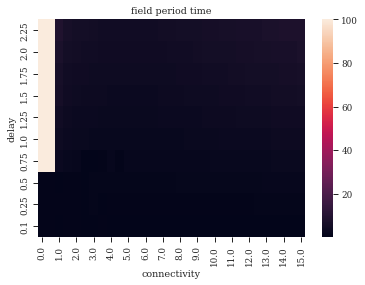

In [19]:
# ax_field_period = sns.heatmap(np.log(field_period_table.abs()), annot=False, vmax = 2, vmin = -2)
ax_field_period = sns.heatmap(field_period_table.abs(), annot=False)
ax_field_period.set_title('field period time')
ax_field_period.invert_yaxis()

In [20]:
fig = ax_field_period.get_figure()
fig.savefig(os.path.join(target_path, 'field_period_phase_space.png'))

C:\Users\mohsen\AppData\Local\Temp/ipykernel_5332/891229783.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


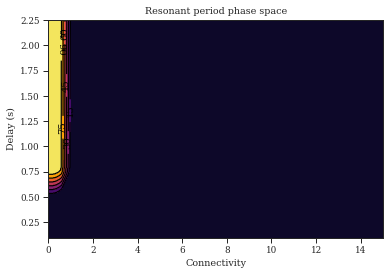

In [21]:
c_fig = create_contour_phase_space(field_period_table.abs().to_dict(), 'Resonant period')
c_fig.savefig(os.path.join(target_path, 'field_period_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

In [22]:
max_intensity_table = dict_to_dataframe(field_max_intensity_mod_glossary_dict)
max_intensity_table.head()

connectivity,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5,15.0
delay,,,,,,,,,,,,,,,,,,,,,
0.10,95.697630,100.132133,88.591155,83.790099,75.894852,121.014673,92.072526,97.779016,95.516825,86.941406,...,1985.850739,1997.508605,2308.370469,2652.068028,2129.266421,2438.624070,2824.686969,2621.968683,2449.074946,2772.051934
0.25,105.857290,116.759889,103.893936,102.546973,115.058300,101.829451,81.342716,91.962917,83.551526,85.434070,...,3893.708308,2838.791311,3742.762899,3147.934520,3641.664799,2899.812330,2987.571114,3645.584306,3036.486633,3497.514166
0.50,125.618804,123.566989,77.828666,101.250450,108.373176,100.226174,98.348181,106.889705,134.179596,142.242691,...,3952.103322,3507.832489,3720.053217,4109.015638,3135.626956,3970.175989,3691.889632,2478.437367,3537.297536,3717.443284
0.75,130.768707,112.195654,99.954833,96.101743,96.253272,122.275303,132.401271,117.423296,133.294113,183.424054,...,3693.394404,4299.984574,3929.568132,4081.712538,3602.837447,3318.189299,3225.234756,3218.413920,3858.117297,3778.989667
1.00,168.437829,144.683158,128.667443,124.041260,125.023425,130.487310,138.163227,151.079119,175.398221,205.401639,...,3781.240757,3278.786432,2776.107690,3063.805405,3674.196977,4073.549171,3656.349506,2750.179138,3723.704345,3666.703418


C:\Users\mohsen\AppData\Local\Temp/ipykernel_5332/891229783.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


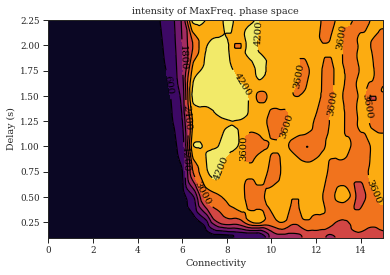

In [23]:
c_fig = create_contour_phase_space(field_max_intensity_mod_glossary_dict, 'intensity of MaxFreq.')
c_fig.savefig(os.path.join(target_path, 'max_intensity_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

In [24]:
# %matplotlib notebook
# from mpl_toolkits.mplot3d import Axes3D

# d_arr = max_intensity_table.index
# g_arr = max_intensity_table.columns
# bars_pos = np.array([np.tile(g_arr, len(d_arr)), np.repeat(d_arr, len(g_arr)), [0]*(len(d_arr)*len(g_arr))])

# dd_arr = d_arr[1] - d_arr[0]
# dg_arr = g_arr[1] - g_arr[0]

# dmax_intensity = max_intensity_table.to_numpy().flatten()

# cmap = plt.cm.get_cmap('magma') # Get desired colormap - you can change this!
# period_arr = field_period_table.to_numpy().flatten()
# max_height = np.max(period_arr)   # get range of colorbars so we can normalize
# min_height = np.min(period_arr)
# # scale each z to [0,1], and get their rgb values
# rgba = [cmap( np.log( k ) ) for k in period_arr] 


# fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
# # ax = fig.add_subplot(111, projection='3d')
# # ax.bar3d(bars_pos[0], bars_pos[1], bars_pos[2], dg_arr, dd_arr, dmax_intensity, color=rgba)